# Data Reduction Tutorial
## A tutorial for the data reduction procedures from Cheng et al. (in prep)

# Introduction
This notebook will take you through how the data reduction was done for Cheng et al. (in prep).  The initial data reduction is done using PypeIt, which we will go through in detail first.  Several external procedures were also written outside of PypeIt, including the flexure and telluric corrections.  Code and examples for these procedures will be provided here.

# PypeIt Data Reduction
The PypeIt documentation is extensive and helpful, and I will refer to it throughout this tutorial.  In particular, check out the [PypeIt Cookbook](https://pypeit.readthedocs.io/en/release/cookbook.html) to get started (I have adapted some of the steps from here to fit this project).  I also recommend joining the [PypeIt Users Slack workspace](https://github.com/pypeit/PypeIt/issues/676) - this is where you can ask the developers questions.  They are very responsive and helpful!

## Installation
Follow the instructions [here](https://pypeit.readthedocs.io/en/release/installing.html).  Be sure to install the [Atmospheric Model Grids](https://pypeit.readthedocs.io/en/release/installing.html#atmospheric-model-grids), which we will use later, and make sure [ginga](https://pypeit.readthedocs.io/en/release/installing.html#ginga-plugins) is working.  

## Setup
Ostensibly, you only need to do this step once for each of the objects that you are reducing (even if you end up having to re-reduce the data for whatever reason).  

0. Following step [0](https://pypeit.readthedocs.io/en/release/cookbook.html#organize-prepare-your-data) in the PypeIt Cookbook, organize your data so that you have one directory for each individual object you are reducing.  The directory should contain all science and calibration frames (you may have to copy your calibration frames into several different directories if you have one set for all of your observations).  **Note that for Keck LRIS, you must reduce the blue and red sides separately**.  So, for example, if I am reducing a globular cluster, I will have one directory for the blue science + calibration frames for this GC and one directory for the red science + calibration frames for this GC.  Note that there are many different possible frametypes that can be used in defined in PypeIt.  However, I have found that at a minimum you need `science` frames, `arc,tilt` (tilts), and `pixelflat,illumflat,trace` (flat field) frames.

1. Following step [1](https://pypeit.readthedocs.io/en/release/cookbook.html#setup), [setup](https://pypeit.readthedocs.io/en/release/setup.html) your reduction.  Change your working directory to one where you would like your reduced data to live (I prefer to work in the directory where my raw files are located).  Run the following command: `pypeit_setup -r <path_to_raw_data> -s <instrument_name>`.  So, for example, if you are reducing data from the Keck LRIS blue arm, and if your raw data is located in `/Users/janedoe/object_name/blue/`, you would run `pypeit_setup -r /Users/janedoe/object_name/blue/ -s keck_lris_blue`.  The options are required:
- `-r` = path to raw data
- `-s` = instrument
This will create a directory called `setup_files`, which will contain the (relevant) file `<spectrograph>_<date>.sorted`

2. Open the `.sorted` file and inspect it.  It will contain each instrument setup that was used in the collection of your data (labelled A, B, C, ...) and a list of frames associated with each.  For each instrument setup, there will be a setup block at the beginning of the section which describes the instrument configuration.  This will be followed by the list of frames, which will automatically have some information assigned to them based on their headers.  Importantly, PypeIt will automatically assign a frametype to each frame (i.e. science, standard, etc.).  Use this file to decide which configuration you would like to reduce (this will be the one where all of your science frames are located).  Below is an example for the M31 GC B058 - in this case I would want to be using Setup A.

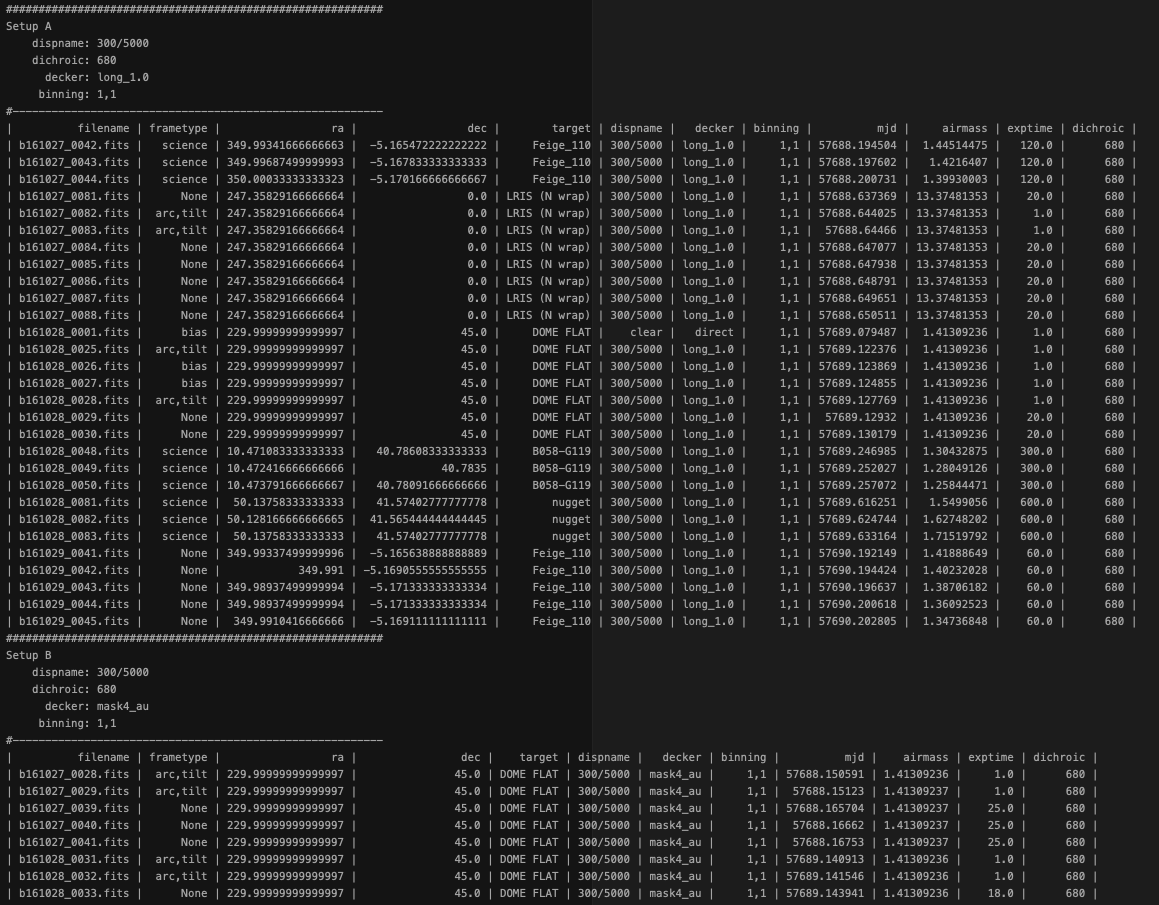

3. Re-run `pypeit_setup` for the setup(s) that you want.  You can do this using the `-c` option.  For example, since I want to use Setup A, I would run `pypeit_setup -r /Users/janedoe/object_name/blue/ -s keck_lris_blue -c A`, which will generate one directory (`keck_lris_blue_A`) and one `.pypeit` file (`keck_lris_blue_B.pypeit`) for this setup.  If you wanted to use two setups, you could run `pypeit_setup -r /Users/janedoe/object_name/blue/ -s keck_lris_blue -c A,B` and if you wanted to access all of the setups you could run `pypeit_setup -r /Users/janedoe/object_name/blue/ -s keck_lris_blue -c all`.  The `.pypeit` file is very important and is what you will use to specify parameters for your reduction. 

## Reduction
### Examining your `.pypeit` reduction file
Open your `.pypeit` reduction file.  Here is an example, using the same object as above:

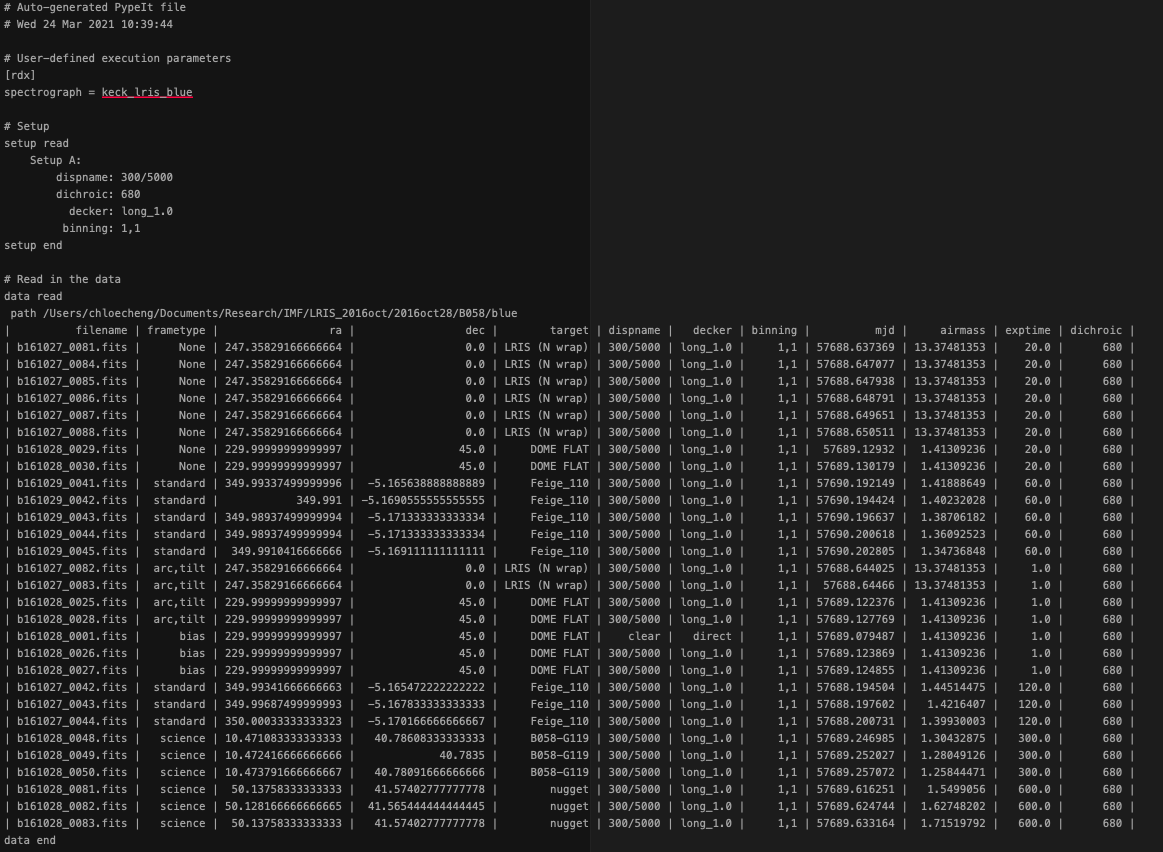

The block under `# User-defined execution parameters` at the top of the file is called the parameter block.  PypeIt will by default add your instrument here under `spectrograph`, but there are several other options that you can add to clarify your reduction, which we will review below.  Underneath this, under `# Setup` is your setup block, which describes your instrument configuration.  You will not need to touch this.  Finally, below this, under `# Read in the data` is your data block, which lists all of the `.fits` files that PypeIt found in your directory.  PypeIt reads in most of the information here from the `.fits` headers.  It also automatically assigns a frametype in the second column - you may need to make adjustments here if PypeIt makes an incorrect assignment, which we will go over as well.  

#### Editing the Data Block
Sometimes, PypeIt will incorrectly assign a frametype.  If you know what the frametype should be, you can change this yourself.  For example, in the image below, I have circled two frames where PypeIt thinks the frametype is "None":

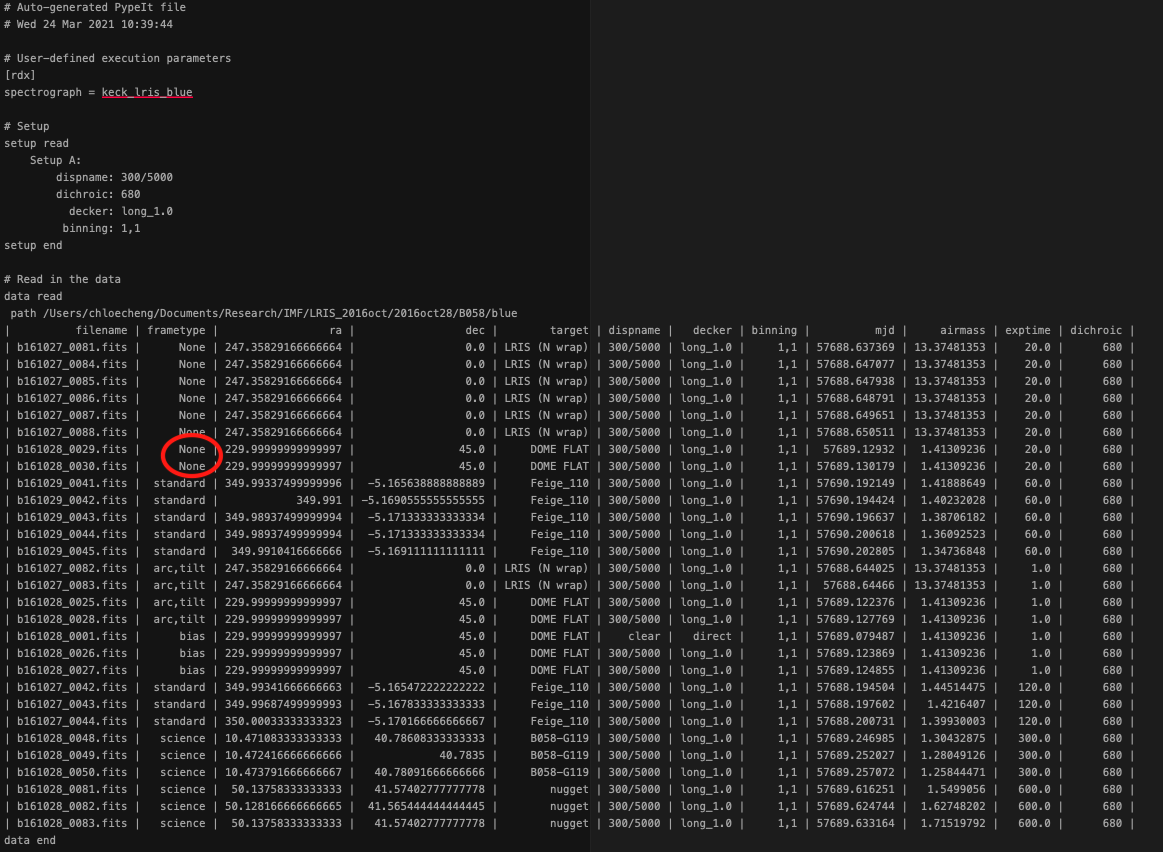

However, I know that these are actually flat field frames, so I can change them as such:

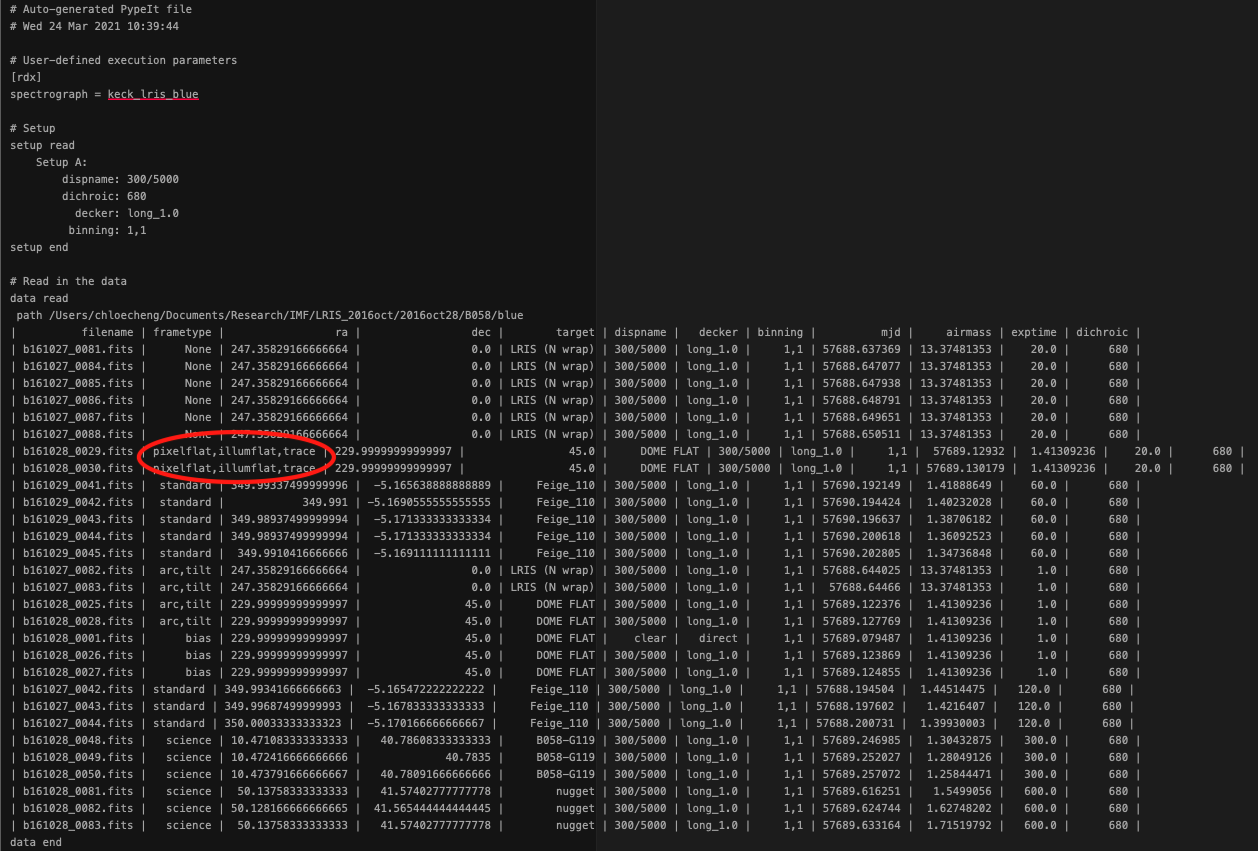

(We'll go over what `pixelflat,illumflat,trace` means in more detail later.)  Other common mistakes that can be made are assigning science frames as standard frames and vice versa. 

### Editing the Parameter Block
PypeIt is flexible in that you can make a wide variety of edits to the parameter block to customize your reduction for your purposes.  Here I'll go through some useful options, and particularly parameters that I made use of in my research.  A full list of the specific parameters used for each object in this study can be found [here](https://docs.google.com/spreadsheets/d/1m1rKS0QG10h7SWaI_GeKfeycSdpiG8CUI_eKOeBhJnY/edit?usp=sharing).  An extensive overview of all of the possible parameters that can be changed in PypeIt is given [here](https://pypeit.readthedocs.io/en/release/pypeit_par.html).

#### [Bias, Darks](https://pypeit.readthedocs.io/en/release/bias_dark.html), and [Flat Fielding](https://pypeit.readthedocs.io/en/release/flat_fielding.html)
You may have frames of all of these types, in which case edits will not necessarily need to be made here.  However, you may not have certain frametypes, or you may not want to use certain frames.  In that case, you can make several customizations under the `[baseprocess]` parameter group.  This is how you can format the parameter group:
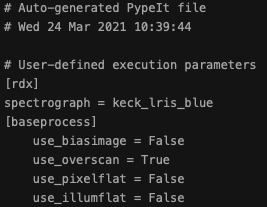

Listed in the image are the parameters that I found useful, which I used for all of my objects:
- `use_biasimage = False`: I did not have bias frames, so I turned off the default biasing
- `use_overscan = True`: I still wanted to bias my frames, so I turned on overscan bias subtraction
- `use_pixelflat = False` and `use_illumflat = False`: I turned off flat fielding.  This is suggested for Keck LRIS by the PypeIt developers (**I think, check this**), and is pretty common for spectroscopic studies.  You will still need to have flat field frames defined as they will need to be used for slit tracing, which we will discuss below.

#### [Calibrations](https://pypeit.readthedocs.io/en/release/calibrations.html)
Many parameters in the `[calibrations]` parameter block can be changed to customize various steps of the calibrations that PypeIt performs.  The order in which calibrations are performed are:
1. Bias and dark subtraction
2. Slit tracing
3. Flexure correction
4. Wavelength calibration
5. Flat fielding

I will go through some key parameter changes that I found useful for some of these steps. 

##### [Slit tracing](https://pypeit.readthedocs.io/en/release/slit_tracing.html)
Slit tracing can be very finnicky.  The biggest issue that I had was PypeIt identifying too many slits (for my purposes, I only had one slit because I was using Keck longslit data).  Here are some parameters in the `[[slitedges]]` sub-block that can help fix this:
- `minimum_slit_length`: The minimum length of the slit in arcseconds.  By trial and error, I usually set this to 10 for blue frames.
- `edge_thresh`: Threshold for finding slit edges.  By trial and error, I usually set this to 50 for red frames. 
- `add_slits`: Sometimes a slit was missing or I could not get the slit to be identified in the correct place.  Then I would manually add a slit (i.e. estimate add_slits = 2:2000:1:328, **find formatting for this, especially on red side, for non-GCs**)
- `rm_slits`: Sometimes you need to remove an extra slit, i.e. PypeIt won't stop picking up 2 slits or more.

##### Wavelength calibration
Here are some parameters in the `[[wavelengths]]` sub-block:
- `n_first`: Order to try first for wavelength calibration fit
- `method`: Method for wavelength calibration (default on blue side is `full_template`, usually just changed red side to match)
- `reid_arxiv`: Need for red side
- `sigdetect`:
- `match_toler`: 

#### Main reduction run
Other important procedures include:
1. Object finding
2. Spectral extraction
3. Sky subtraction
4. Flexure correction
These can be modified in the `[reduce]` parameter block.

##### Object finding
Here are some parameters in the `[[findobj]]` sub-block:
- `sig_thresh`:
- `maxnumber`: Maximum number of objects to extract from the slit (1 in this case)
- `find_fwhm`: FWHM of the object to be extracted (helps PypeIt detect the object if the FWHM is small)
- `find_trim_edge`:

##### Extraction
Here are some parameters in the `[[extraction]]` sub-block:
- `use_2dmodel_mask`:
- `use_user_fwhm`: only important for NGC 247
- `boxcar_radius`: only important for NGC 247

##### Sky subtraction
Here are some parameters in the `[[skysub]]` sub-block:
- `sky_sigrej`: 

##### Flexure correction
Since we do our own flexure correction procedure, we need to turn off the flexure correction in one copy of the reduction, in the `[[flexure]]` sub-block:
- `spec_method`: